In [92]:
import pandas as pd
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import cvxopt
import cvxopt.solvers
import random

#function to normalize data and remove columns with only 0s
def normalize(data):
    data = np.delete(data,np.where(~data.any(axis=0))[0], axis=1)
    data = (data - np.mean(data,axis=0))/np.std(data,axis=0)
    return data

#function to calculate error rate
def error_rate(x,y,w,b):
    res = np.dot(x,w) + b
    res[res>=0] = 1
    res[res<0] = -1
    err = 0
    for i in range(len(y)):
        if(res[i]!=y[i]):
            err +=1
    return(err/len(y))

#function to solve quadratic problem using cvxopt
def solver(x,y,C):
    N,M = x.shape
    # obtain the kernel
    K = y[:, None] * x
    K = np.dot(K, K.T)
    P = cvxopt.matrix(K)
    q = cvxopt.matrix(-np.ones((N, 1)))
    #to ensure the constraints are maintained we stack g1,g2 and h1,h2
    G1 = np.diag(np.ones(N) * -1)
    G2 = np.identity(N)
    G = cvxopt.matrix(np.vstack((G1, G2)))
    H1 = np.zeros(N)
    H2 = np.ones(N) * C
    h = cvxopt.matrix(np.hstack((H1, H2)))
    A = cvxopt.matrix(y.reshape(1, -1))
    b = cvxopt.matrix(np.zeros(1))
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

#main function which takes file as input and C
def myDualSVM(file,C):
    folds = 10
    file = file.values    
    #change labels to +1 and -1 and normalize data
    file[:,0][file[:,0]==1] = 1 
    file[:,0][file[:,0]==3] = -1
    temp = normalize(file[:,1:]) 
    data = np.append(file[:,0][None].T,temp,axis=1)
    
    #shuffle data randomly to obtain random subsets 
    np.random.shuffle(data) 
    
    #code to apply k-fold on the train data
    M,N = data.shape
    fold = int(M/folds)-1
    first = 0
    last = fold
    subset = np.zeros((folds,fold,N))
    #subset the data based on number of folds
    for i in range(folds-1):
        subset[i,:,:] = data[first:last]
        first = last + 1
        last = first + fold
    #copy remaining rows into subset
    subset[i+1,:,:] = data[first:last]
    train_error_rate = np.zeros(folds-1) 
    validation_error_rate = np.zeros(folds-1) #number of folds - 1 -> total number of error rates reported
    num_supp_vectors = np.zeros(folds-1)
    for i in range(1): #run this loop only 1 times for sake of speed
        #remove the test data from the train data and reshape the data to a 2d Array
        test1 = subset[i]
        k=0
        for j in range(i+1,folds): #select 2 folds as test and 8 folds as train
            train = data #stores full data into train
            train = np.delete(subset,i,axis=0) #remove fold i from train
            test = np.append(test1,subset[j],axis=0) #adds fold j to test data
            train = np.delete(subset,j,axis=0) #remove fold j from train data
            L,M,N = train.shape
            train=train.reshape(L*M,N)
            x = train[:,1:]
            y = train[:,0]
            print("Solving quadratic problem using cvxopt...")
            cvxopt.solvers.options['show_progress'] = False
            alpha = solver(x,y,C) #run cvxopt quadratic solver on the train data and train label
            #solve for w and b 
            index = (alpha > 1e-8).reshape(-1) 
            num_supp_vectors[k] = sum(index) #number of support vectors selected
            w = np.sum(alpha[index] * y[index, None] * x[index], axis = 0)
            # get b only where alphas are above some threshold like 10^-7 (less than they are almost 0)
            b = y[index] - np.dot(x[index], w)
            bias = np.mean(b)
            #training error rate
            train_error_rate[k] = error_rate(x,y,w,bias)
            #validation error rate
            x = test[:,1:]
            y = test[:,0]
            validation_error_rate[k] = error_rate(x,y,w,bias)
            k=k+1
    rate = validation_error_rate*100
    mean_rate = np.mean(rate)
    std_rate = np.std(rate)
    print("The mean of test error is =",mean_rate)
    print("The standard deviation of test error =",std_rate)
    #print(rate*100)
    return train_error_rate,validation_error_rate,num_supp_vectors

file = pd.read_csv("MNIST-13.csv") #dataset must be in same folder as the python notebook for this line to work
C = [0.01,0.1,1,10,100]
train_error_rate = np.zeros((5,9))
validation_error_rate = np.zeros((5,9))
num_supp_vectors = np.zeros((5,9))
k=0
for c in C:
    print("With C =",c)
    train_error_rate[k],validation_error_rate[k],num_supp_vectors[k] = myDualSVM(file,c) #to store all error rates for different values of C for plotting purposes
    k = k+1

With C = 0.01
Solving quadratic problem using cvxopt...
Solving quadratic problem using cvxopt...
Solving quadratic problem using cvxopt...
Solving quadratic problem using cvxopt...
Solving quadratic problem using cvxopt...
Solving quadratic problem using cvxopt...
Solving quadratic problem using cvxopt...
Solving quadratic problem using cvxopt...
Solving quadratic problem using cvxopt...
The mean of test error is = 0.505050505051
The standard deviation of test error = 0.291591045045
With C = 0.1
Solving quadratic problem using cvxopt...
Solving quadratic problem using cvxopt...
Solving quadratic problem using cvxopt...
Solving quadratic problem using cvxopt...
Solving quadratic problem using cvxopt...
Solving quadratic problem using cvxopt...
Solving quadratic problem using cvxopt...
Solving quadratic problem using cvxopt...
Solving quadratic problem using cvxopt...
The mean of test error is = 0.505050505051
The standard deviation of test error = 0.16835016835
With C = 1
Solving quadr

In [52]:
#Suppress cvxopt output, check requirements of report and add it to report
one = [1,2,3,4,5,6,7,8,9]

For C=0.01 the train error rates for each fold were:
[ 0.0016835   0.0016835   0.0016835   0.00112233  0.0016835   0.0016835   0.
  0.00224467  0.0016835 ]
For C=0.01 the validation error rates for each fold were:
[ 0.          0.00505051  0.01515152  0.01010101  0.00252525  0.00252525
  0.01010101  0.01515152  0.00505051]


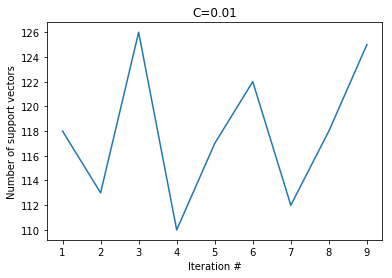

In [71]:
print("For C=0.01 the train error rates for each fold were:")
print(train_error_rate[0])
print("For C=0.01 the validation error rates for each fold were:")
print(validation_error_rate[0])
x=one
y=num_supp_vectors[0]
plt.plot((x), (y))
plt.xlabel('Iteration #')
plt.ylabel('Number of support vectors')
plt.title('C=0.01')
plt.show()

For C=0.1 the train error rates for each fold were:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
For C=0.1 the validation error rates for each fold were:
[ 0.01010101  0.00252525  0.00757576  0.00505051  0.01262626  0.00505051
  0.00505051  0.00505051  0.        ]


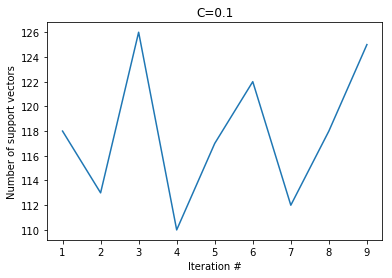

In [72]:
C = [0.01,0.1,1,10,100]
print("For C=0.1 the train error rates for each fold were:")
print(train_error_rate[1])
print("For C=0.1 the validation error rates for each fold were:")
print(validation_error_rate[1])
x_axis=one
y_axis=num_supp_vectors[1]
plt.plot((x), (y))
plt.xlabel('Iteration #')
plt.ylabel('Number of support vectors')
plt.title('C=0.1')
plt.show()

For C=1 the train error rates for each fold were:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
For C=1 the validation error rates for each fold were:
[ 0.00757576  0.00505051  0.00757576  0.01262626  0.01262626  0.00252525
  0.00757576  0.00505051  0.00252525]


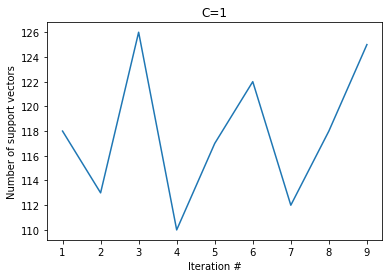

In [73]:
print("For C=1 the train error rates for each fold were:")
print(train_error_rate[2])
print("For C=1 the validation error rates for each fold were:")
print(validation_error_rate[2])
x_axis=one
y_axis=num_supp_vectors[2]
plt.plot((x), (y))
plt.xlabel('Iteration #')
plt.ylabel('Number of support vectors')
plt.title('C=1')
plt.show()

For C=10 the train error rates for each fold were:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
For C=10 the validation error rates for each fold were:
[ 0.00757576  0.01515152  0.00505051  0.00252525  0.01010101  0.00505051
  0.00757576  0.00505051  0.00252525]


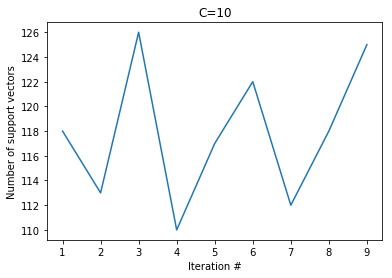

In [74]:
print("For C=10 the train error rates for each fold were:")
print(train_error_rate[3])
print("For C=10 the validation error rates for each fold were:")
print(validation_error_rate[3])
x_axis=one
y_axis=num_supp_vectors[3]
plt.plot((x), (y))
plt.xlabel('Iteration #')
plt.ylabel('Number of support vectors')
plt.title('C=10')
plt.show()

For C=100 the train error rates for each fold were:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
For C=100 the validation error rates for each fold were:
[ 0.00252525  0.00757576  0.00757576  0.00505051  0.00505051  0.00505051
  0.00252525  0.00505051  0.00505051]


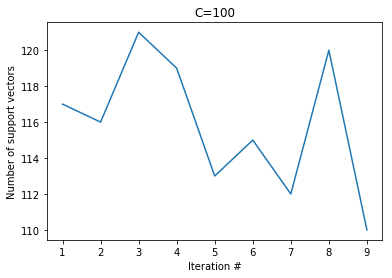

In [75]:
print("For C=100 the train error rates for each fold were:")
print(train_error_rate[4])
print("For C=100 the validation error rates for each fold were:")
print(validation_error_rate[4])
x=one
y=num_supp_vectors[4]
plt.plot((x), (y))
plt.xlabel('Iteration #')
plt.ylabel('Number of support vectors')
plt.title('C=100')
plt.show()

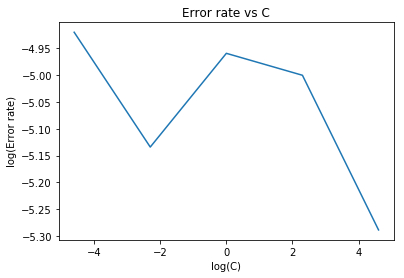

In [90]:
x=np.log(C)
y=np.log(np.mean(validation_error_rate,axis=1))
plt.plot(x, y)
plt.xlabel('log(C)')
plt.ylabel('log(Error rate)')
plt.title('Error rate vs C')
plt.show()

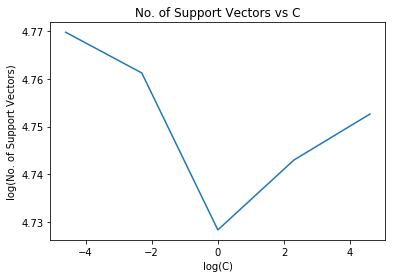

In [89]:
x=np.log(C)
y=np.log(np.mean(num_supp_vectors,axis=1))
plt.plot(x, y)
plt.xlabel('log(C)')
plt.ylabel('log(No. of Support Vectors)')
plt.title('No. of Support Vectors vs C')
plt.show()

In [50]:
print(np.mean(num_supp_vectors,axis=1))

[ 117.88888889  116.88888889  113.11111111  114.77777778  115.88888889]
